# Other pole locations of radiation integrand

We have begun to understand that the leaky modes propagation constants are part of the set of pole locations of the extension of the radiation integrand to the complex plane.  They are specifically the locations where there is only an outgoing component to the full time-space mode associated with the propagation constant at that location in $\mathbb{C}$.  But there may be other poles of the integrand.  These will be places where the coefficients of the radiation modes blow up.  In this notebook, we investigate these poles for the case of the hollow core waveguide in various configurations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact, plot_complex
from scipy.optimize import newton
from IPython.display import HTML

%matplotlib widget
plt.style.use('dark_background')

In [16]:
A = SlabExact(scale=1e-6, Ts=[5, 1, 4, 1, 5],
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[500, 300, 300, 300, 500],
              symmetric=True, wl=1e-6)

In [17]:
b = 1.25
def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x/b)**2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

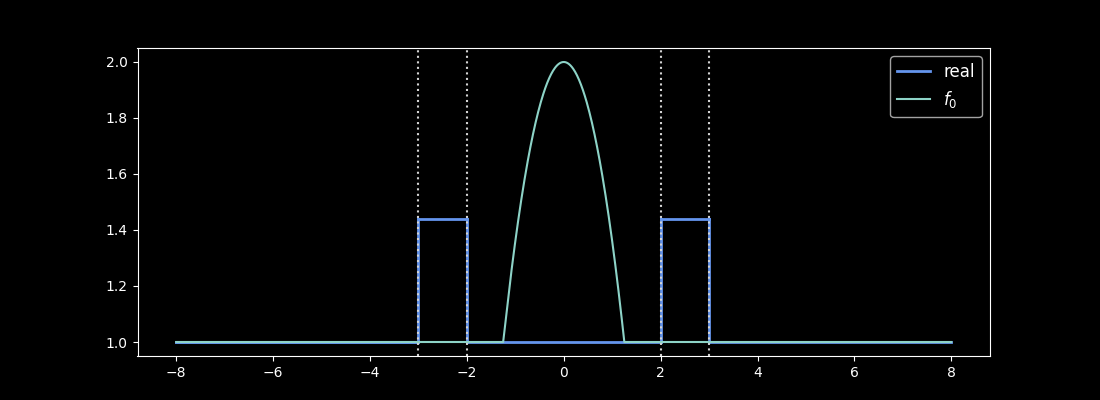

In [18]:
A.plot_refractive_index(color='cornflowerblue', linewidth=2);
A.add_1d_plot(lambda x: f0(x) + 1, label='$f_0$')

## Poles of radiation integrand

These occur where the radiation mode coefficients become infinite.  If we didn't know this a priori, we would look at the spectral integrand for a given input function:

In [19]:
A.spectral_integrand?

Signature:
A.spectral_integrand(
    Cs,
    f0,
    x=0,
    z=0,
    Lx=None,
    Rx=None,
    plane='Z',
    class_A_only=False,
    class_B_only=False,
    field_type='TE',
    alpha_A=None,
    alpha_B=None,
    Normalizer=None,
)
Docstring: Return integrand of radiation expansion of f0 at Cs, x, z.
File:      ~/local/slab/slab.py
Type:      method

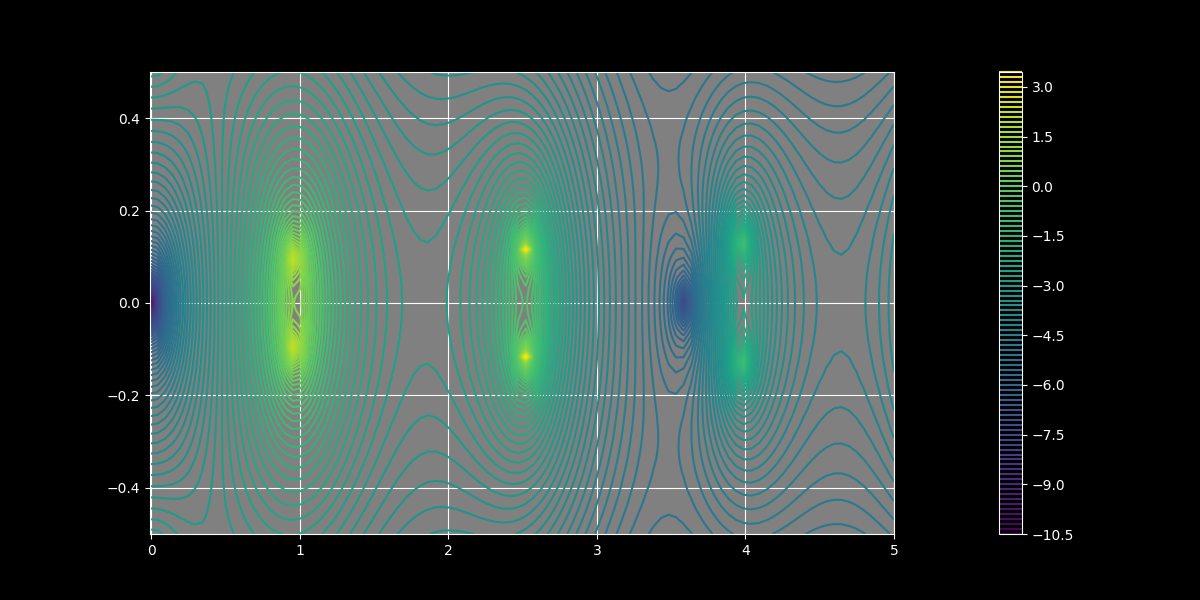

In [23]:
Lx, Rx = -b, b
ft, sign = 'TE', 1

fkwargs = {'f0': f0, 'x': 0, 'z': 0, 'Lx': Lx, 'Rx':Rx, 
           'class_A_only': False, 'class_B_only': False, 
           'field_type': ft, 'Normalizer': A.normalizer('ours')}

plot_complex(A.spectral_integrand, -.01, 5, -.5, .5, fkwargs=fkwargs, rref=100, iref=100, levels=100)

We want to find these independently of the input function, which should be possible because only the radiation mode coefficients determine where the above poles lie (since the input functions themselves are assumed bounded and with compact support and hence do not contribute to blow up of the radiation integral).  We created a built in function to find these locations:

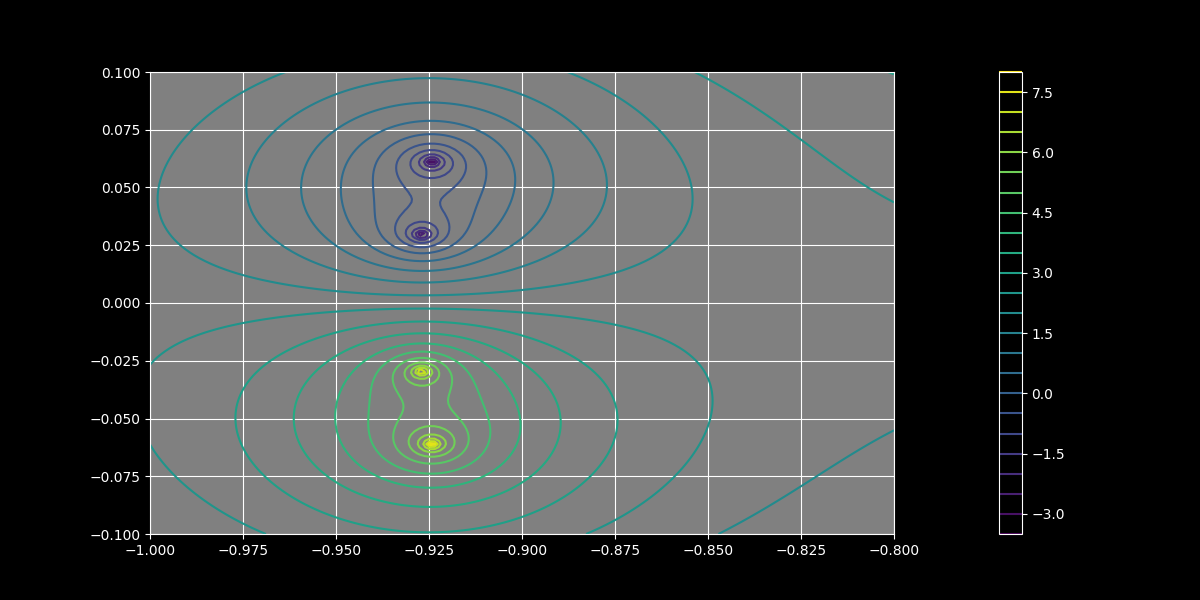

In [6]:
ft = 'TE'
paper_method = True
sign = None
fargs = (ft, sign, paper_method)

plot_complex(A.radiation_poles_as_zeros, -1, -.8, -.1, .1, fargs=fargs, rref=150, iref=150, log_abs=True)

By plotting with sign = 1 and -1 instead of None, we determine that the upper root is class 1 (positive sign) and the lower root both class 1 and class 2 (negative sign).  Now we find them and add them to the plot.

In [7]:
Zp = newton(A.radiation_poles_as_zeros, np.array(-.922+.06j), args=fargs, tol=1e-3)
Zm = newton(A.radiation_poles_as_zeros, np.array(-.926+.029j), args=fargs, tol=1e-3)
Zs = [Zp, Zm]

A.plot_points(Zs, ms=5)


Prior to building the fields there, let's see if any of these locations correspond to a leaky or guided mode location

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

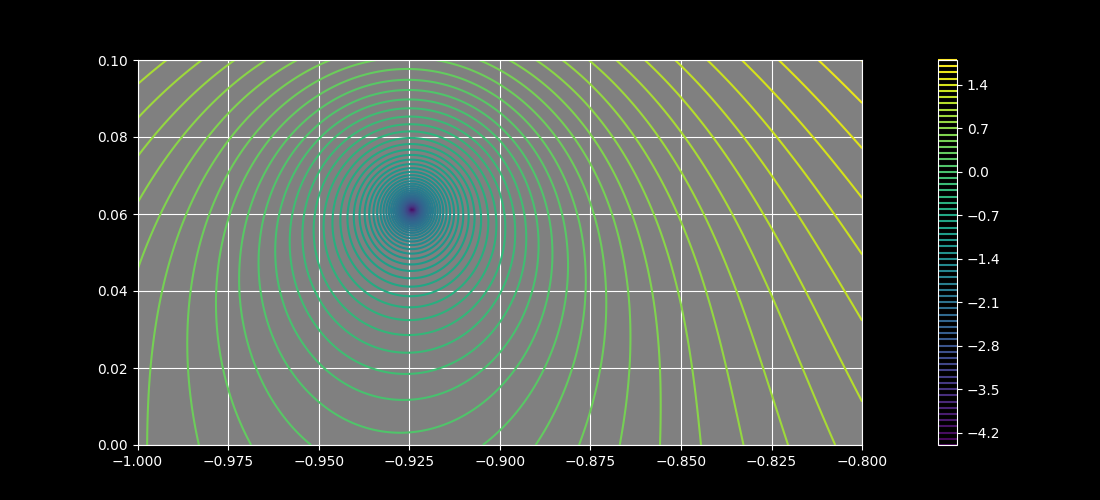

In [8]:
A.determinant_plot(-1, -.8, 0, .1, mode_type='leaky', plot_y_axis=False)

In [9]:
A.plot_points(Zs, ms=5)

It appears the upper location is a true leaky mode.

The built-in function is very general: it can take any specification of radiation mode classes and find the poles.  However, it is not well-conditioned. We have better methods now:

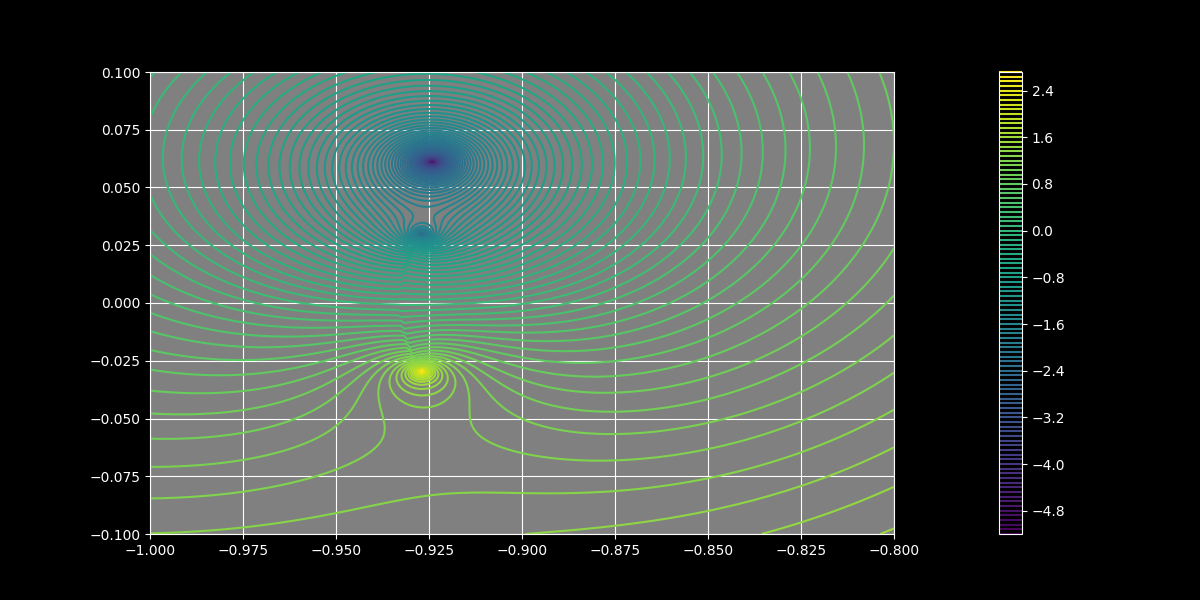

In [10]:
N = A.radiation_normalization_class('paper')()
plot_complex(N.pole_locations, -1, -.8, -.1, .1, fargs=(1, 'TE'), rref=250, iref=250, levels=120, log_abs=True)

In [11]:
Zp2 = newton(N.pole_locations, np.array(-.922+.06j), args=(1,'TE'))
Zm2 = newton(N.pole_locations, np.array(-.926+.029j), args=(1,'TE'))
Zs2 = [Zp2, Zm2]

A.plot_points(Zs, ms=5)

In [12]:
Propagator_Class = A.propagator()

In [13]:
Pp = Propagator_Class(A.circular_contour(Zp2, .01, 15), f0, Lx=-b, Rx=b, sign=1)
Pm = Propagator_Class(A.circular_contour(Zm2, .01, 15), f0, Lx=-b, Rx=b, sign=-1)

Ppf = lambda x: Pp.slice_propagate(x)
Pmf = lambda x: Pm.slice_propagate(x)

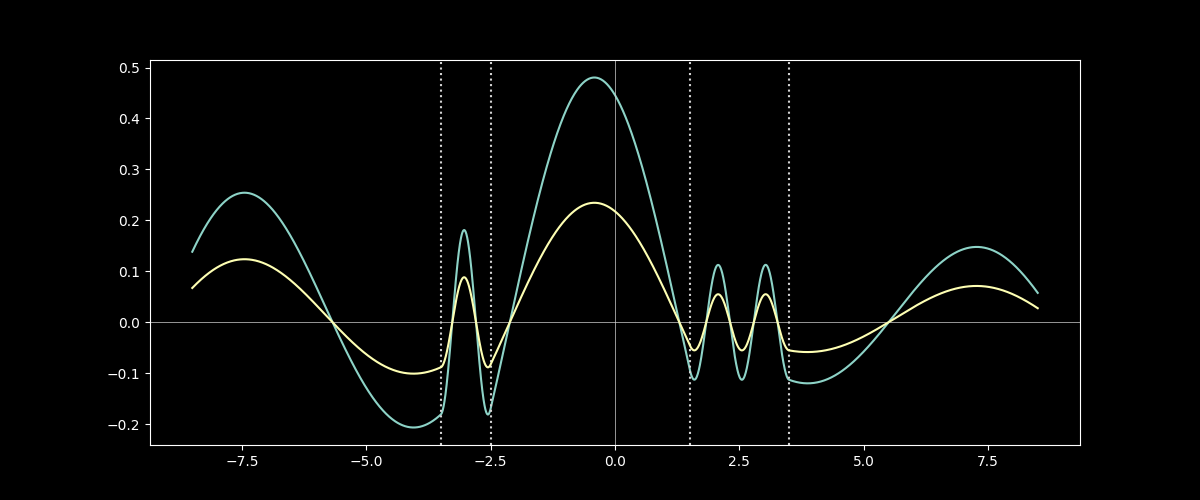

In [14]:
A.plot_field_1d(Ppf)
A.add_1d_plot(Pmf)

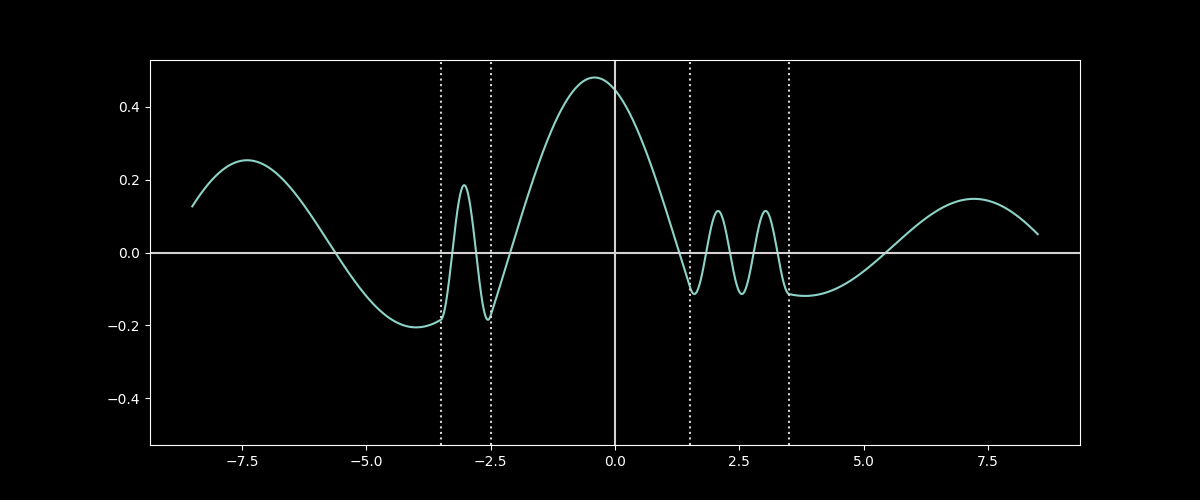

In [47]:
A.animate_field_1d(Ppf, 'field_upper', color='C0')

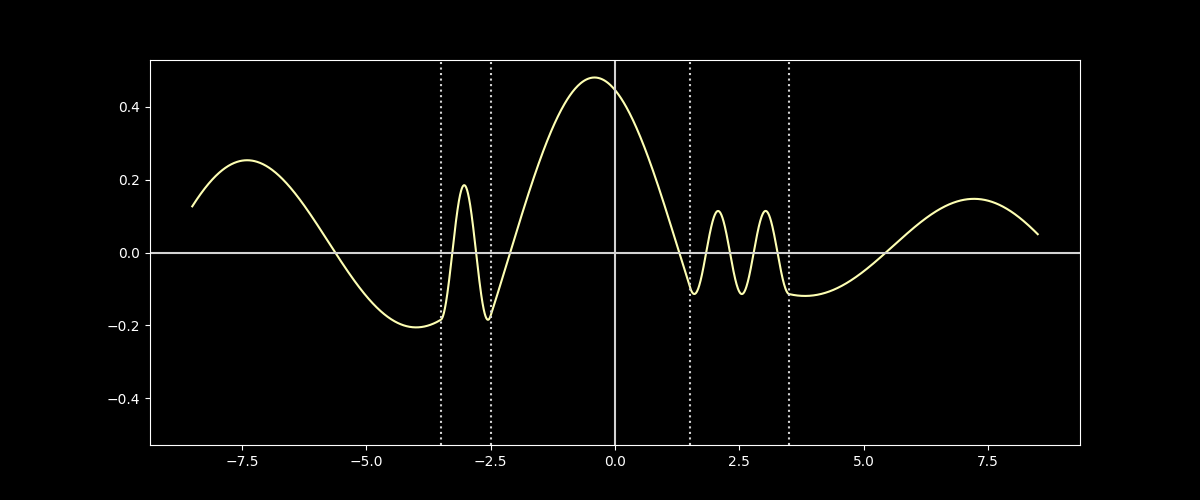

In [48]:
A.animate_field_1d(Ppf, 'field_lower', color='C1')

In [49]:
HTML("""
<video alt="test" controls id="theVideo">
        <source src="field_upper.mp4" type="video/mp4">
</video>

<script>
video = document.getElementById("theVideo")
video.playbackRate = 1;
video.loop = true;
</script>
""")

In [50]:
HTML("""
<video alt="test" controls id="theVideo2">
        <source src="field_lower.mp4" type="video/mp4">
</video>

<script>
video2 = document.getElementById("theVideo2")
video2.playbackRate = 1;
video2.loop = true;
</script>
""")

# Other normalization of radiation modes

Hard to tell if the lower mode in fact doesn't have purely outgoing behavior...  Let's try with our normalization:

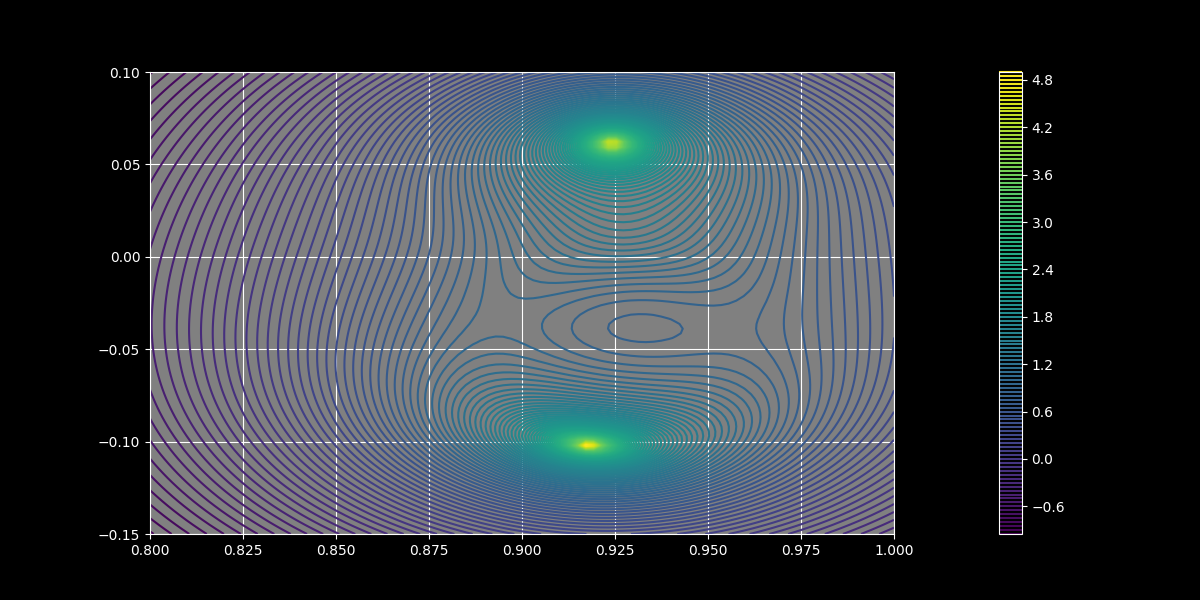

In [51]:
Lx, Rx = -b, b
ft, sign = 'TE', 1
paper_method = False
fargs = (f0, 0, 0, Lx, Rx, False, False, ft, paper_method)

plot_complex(A.spectral_integrand, .8, 1, -.15, .1, fargs=fargs, rref=100, iref=100, levels=120)

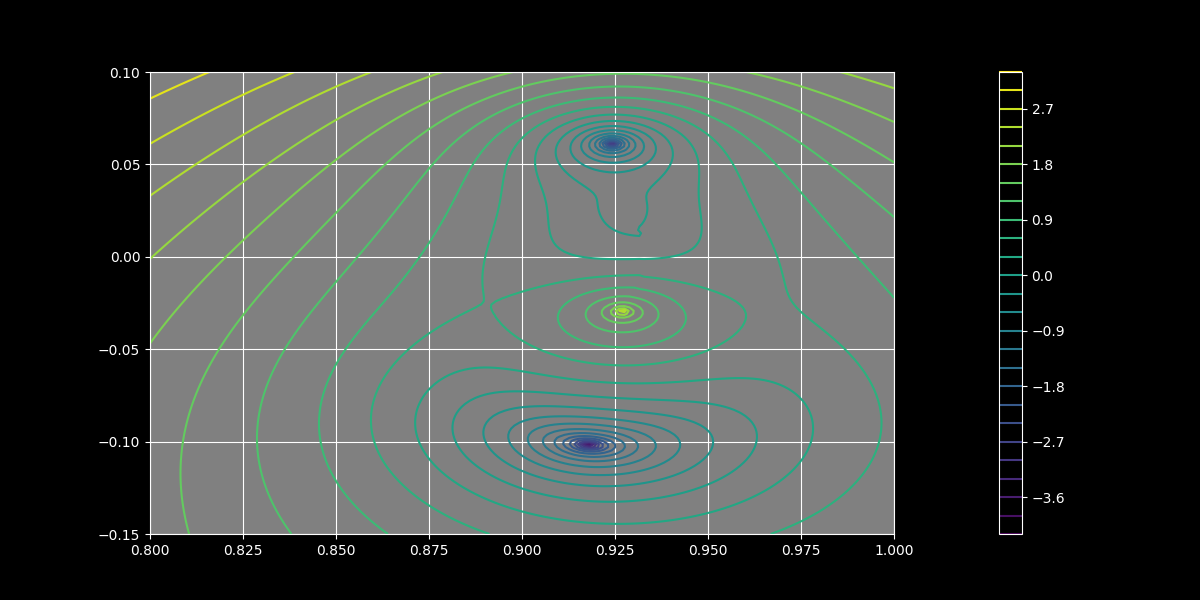

In [60]:
ft = 'TE'
paper_method = False
sign = 1
fargs = (ft, sign, paper_method)
N = A.radiation_normalization_class('ours')()

plot_complex(N.pole_locations,.8, 1., -.15, .1,  fargs=(1, 'TE'), rref=150, iref=150, log_abs=True)

Investigations reveal that the lower pole is only present for sign = 1.  The upper pole is actually present for both.  This raises possibility that the upper one might cancel if we were to use it in integration.  However, SDP is below real axis here, so we don't care about upper pole.

In [61]:
Zm3 = newton(N.pole_locations, np.array(.918-.102j), args=(1, 'TE'))
Zs3 = [Zm3]

A.plot_points(Zs3, ms=5)


Prior to building the fields there, let's see if any of these locations correspond to a leaky or guided mode location

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

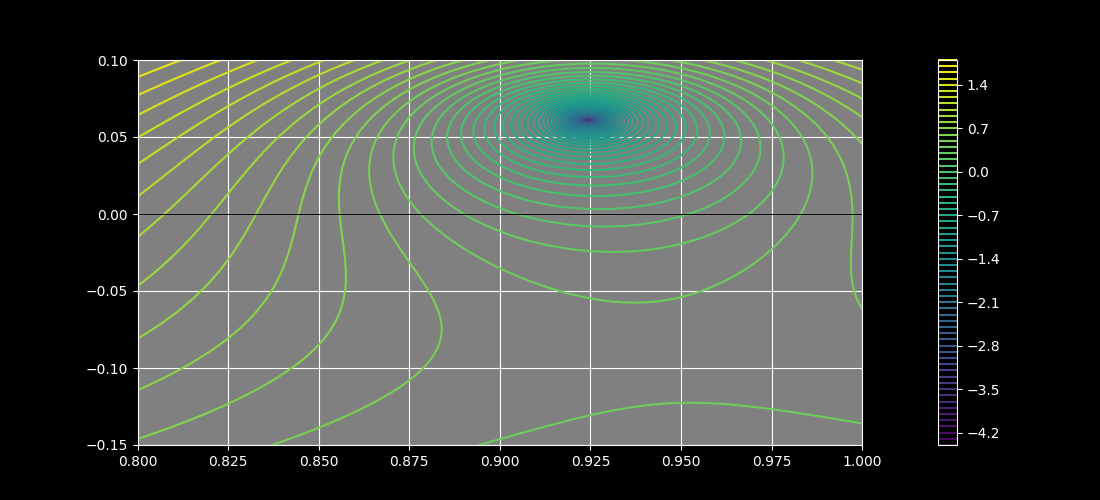

In [62]:
A.determinant_plot( .8, 1, -.15, .1,   mode_type='leaky', plot_y_axis=False)

In [63]:
A.plot_points(Zs, ms=5)

Looks like the lower pole is not a leaky mode.

In [64]:
Propagator_Class = A.propagator()

In [65]:
Pm3 = Propagator_Class(A.circular_contour(Zm3, .01, 15), f0, Lx=-b, Rx=b, sign=1)

pm3f = lambda x: -Pm3.slice_propagate(x)
Pm3f = lambda x, z: -Pm3.propagate(x,z)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

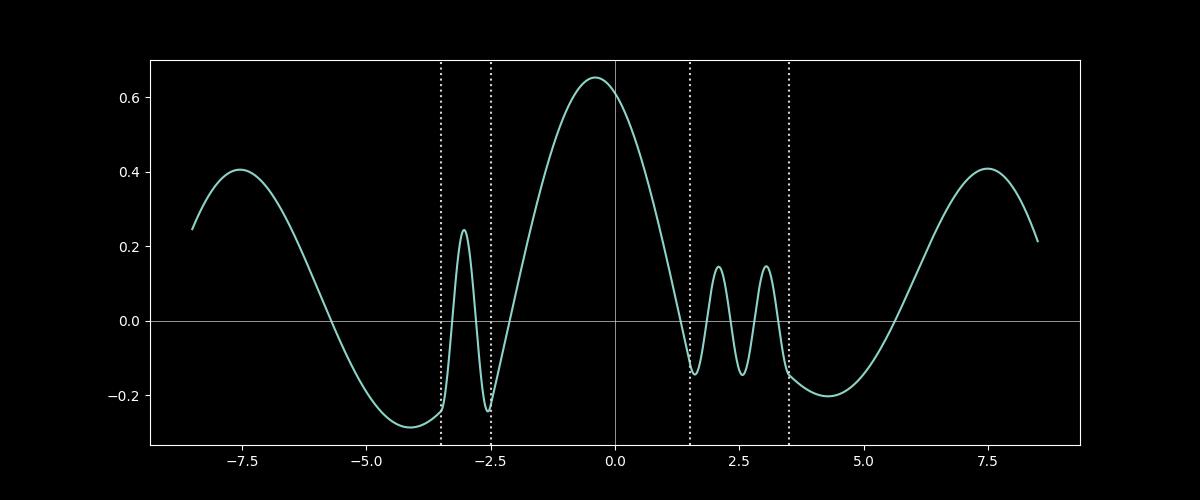

In [66]:
A.plot_field_1d(pm3f)


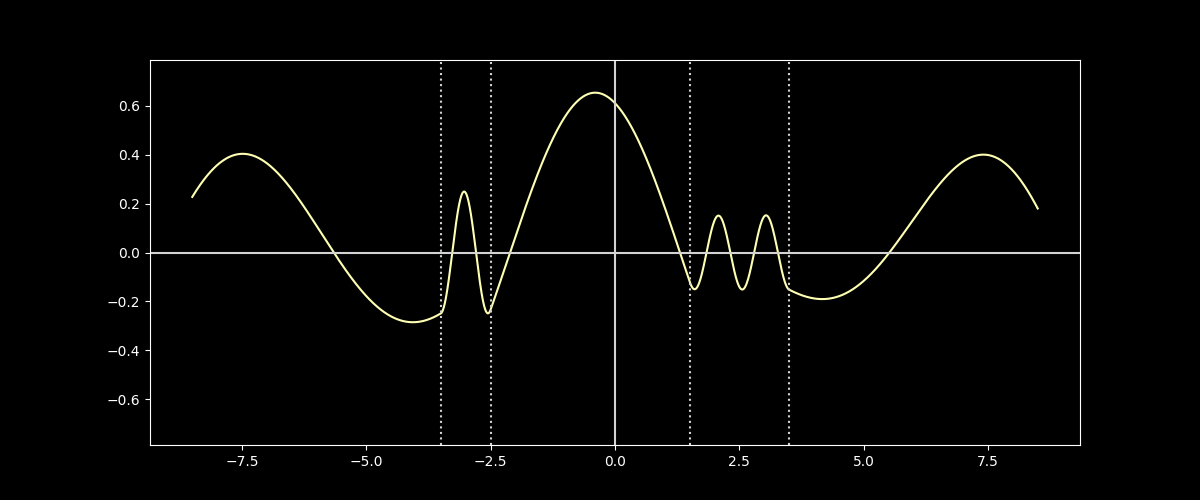

In [67]:
A.animate_field_1d(pm3f, 'field_lower2', color='C1')

In [68]:
HTML("""
<video alt="test" controls id="theVideo3">
        <source src="field_lower2.mp4" type="video/mp4">
</video>

<script>
video3 = document.getElementById("theVideo3")
video3.playbackRate = 1;
video3.loop = true;
</script>
""")

Now we clearly see the waves in the outer regions are clearly not purely outgoing.  Mainly on the right side.  Is the behavior on the left purely outgoing?  To know that, we would likely need to know how to build these fields directly, which we still need to figure out.  That's work for another notebook.

(<Figure size 900x450 with 2 Axes>, <Axes: >)

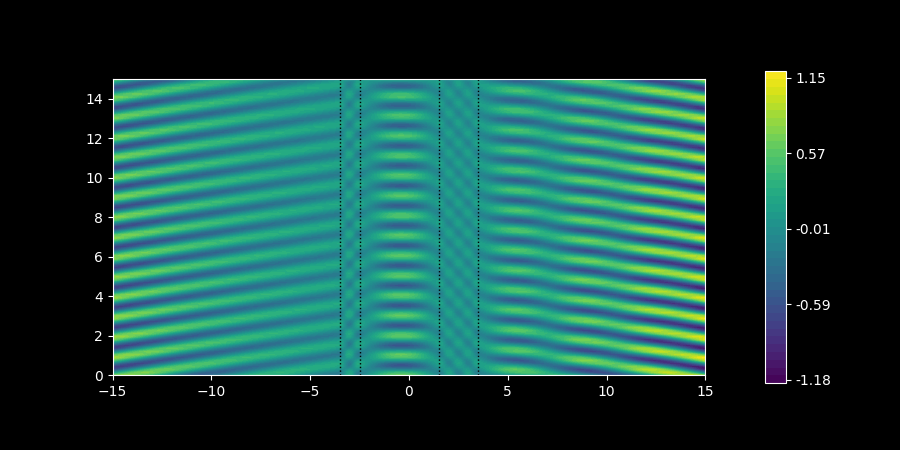

In [69]:
A.plot_field_2d(Pm3f, xs=np.linspace(-15, 15, 1000), zmax=15)

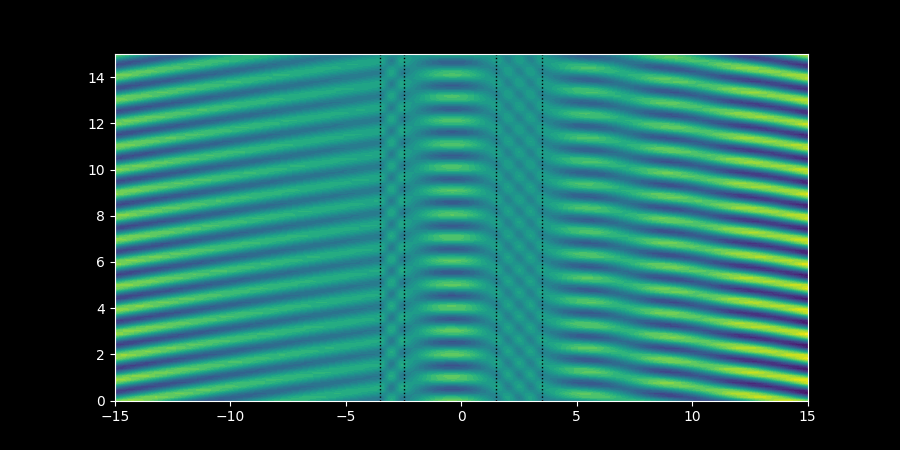

In [70]:
A.animate_field_2d(Pm3f, 'twod', xs=np.linspace(-15, 15, 1000), zmax=15,)

In [71]:
HTML("""
<video alt="test" controls id="theVideo4">
        <source src="twod.mp4" type="video/mp4">
</video>

<script>
video4 = document.getElementById("theVideo4")
video4.playbackRate = 1;
video4.loop = true;
</script>
""")

# Observations and Conclusions

This notebook has thoroughly investigated the nature of the other poles arising in the radiation integrand and the fields they give rise to in the integration process through circular contour integrals enclosing them.  The next step will be to see if they do come in to play in the actual leaky mode breakdown of propagating input fields.  This means, is there some choice of radiation mode classes such that only true leaky modes need to appear in this breakdown?  Do we already have this?  For this, another notebook is in order.